<div align="center">

## 🛡️ RepoAura
#### *Intelligent Governance & Risk Prediction for Software Projects*

</div>

<br>

---

<br>

### 1. Introduction & Problem Characterization
**RepoAura** is an intelligent system designed to evaluate the **health and risk** of software projects. Traditional project management relies on lagging indicators. RepoAura aims to provide leading indicators by analyzing historical patterns of code complexity, churn, bugs, and testing coverage.

The dataset is exclusively sourced from open-source projects, leveraging their accessibility and extensive historical records for academic research. By utilizing real-world data to validate project health, we ensure that Repo-aura is robust and applicable to diverse repository types.

In the context of modern DevOps, identifying modules at high risk of failure before deployment is critical to maintaining velocity without sacrificing quality.

### 2. Objectives

#### General Objective
> Develop a hybrid predictive rule-based & deep learning system, to identify software modules with a high probability of technical debt and defects, enabling proactive refactoring.

#### Specific Objectives
1.  **Characterization:** Analyze historical metrics to understand the correlation between code complexity and project risk.
2.  **Heuristic Filtering:** Implement logical quality gates (Rule-Based System) to detect obvious violations.
3.  **Predictive Modeling:** Train a Recurrent Neural Network (RNN) to detect subtle degradation trends over time.
4.  **Optimization:** Use search algorithms to recommend the most cost-effective refactoring path.


<br>
<br>

---

<br>
<br>

## Data analisys

In this section, we will read and organize the datasets that will help us train and validate the neural network's performance. We will also analyze the data we have and what we will use it for, as it provides us with value and validates whether we are actually meeting the project's objective.

First, let's import the dependencies for this notebook. These contain everything needed for data processing, visual analysis of datasets, managing neural networks, training them, defining rules, etc.

In [ ]:
# Setup Environment
%load_ext autoreload
%autoreload 2

# Imports
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add src to path just in case
sys.path.append(os.path.abspath(os.path.join('..')))
from src.config import Config

print("All imports were correct")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All imports were correct


Once we have all the import requirements to start this project, we will need to upload all the data from the dataset. In this case, we are going to use the datasets obtained from NASA open source projects (https://github.com/ApoorvaKrisna/NASA-promise-dataset-repository). In these datasets, we see basic data that shows us how this project was developed, using indices and data that are represented as follows:

In [ ]:
# Load one raw dataset as example
df_raw = pd.read_csv(Config.RAW_DIR / "cm1.csv")
print("Raw Dataset Sample (CM1 - NASA Project)")
print("-" * 60)
display(df_raw.head(6))

print("\nColumn Definitions:")
print("-" * 60)

columns_info = {
    # Size Metrics
    "loc": "Lines of Code - Total physical lines in the module",
    "lOCode": "Lines of Code (executable) - Actual code lines",
    "lOComment": "Lines of Comments - Documentation lines",
    "lOBlank": "Blank Lines - Empty lines for readability",
    
    # Complexity Metrics
    "v(g)": "Cyclomatic Complexity - Number of independent paths",
    "ev(g)": "Essential Complexity - Unstructured complexity",
    "iv(g)": "Design Complexity - Module coupling measure",
    
    # Halstead Metrics
    "n": "Program Length - Total operators + operands",
    "v": "Volume - Size in bits to store the program",
    "l": "Level - Abstraction level (inverse of difficulty)",
    "d": "Difficulty - Error proneness measure",
    "i": "Intelligence - Logical content of the program",
    "e": "Effort - Mental effort to develop",
    "b": "Bugs Estimate - Predicted number of bugs (V/3000)",
    "t": "Time - Estimated development time (E/18 seconds)",
    
    # Operators & Operands
    "uniq_Op": "Unique Operators - Distinct operators count",
    "uniq_Opnd": "Unique Operands - Distinct operands count", 
    "total_Op": "Total Operators - All operator occurrences",
    "total_Opnd": "Total Operands - All operand occurrences",
    
    # Other
    "branchCount": "Branch Count - Decision points in code",
    "defects": "Defects - TARGET: Has bugs? (true/false)",
}

for col in df_raw.columns:
    if col in columns_info:
        print(f"  - {col:13} -> {columns_info[col]}")

Raw Dataset Sample (CM1 - NASA Project)
------------------------------------------------------------


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False
5,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False



Column Definitions:
------------------------------------------------------------
  - loc           -> Lines of Code - Total physical lines in the module
  - v(g)          -> Cyclomatic Complexity - Number of independent paths
  - ev(g)         -> Essential Complexity - Unstructured complexity
  - iv(g)         -> Design Complexity - Module coupling measure
  - n             -> Program Length - Total operators + operands
  - v             -> Volume - Size in bits to store the program
  - l             -> Level - Abstraction level (inverse of difficulty)
  - d             -> Difficulty - Error proneness measure
  - i             -> Intelligence - Logical content of the program
  - e             -> Effort - Mental effort to develop
  - b             -> Bugs Estimate - Predicted number of bugs (V/3000)
  - t             -> Time - Estimated development time (E/18 seconds)
  - lOCode        -> Lines of Code (executable) - Actual code lines
  - lOComment     -> Lines of Comments - Documentat

### Data detailed

Although this data is very useful in itself, it needs to be manipulated to normalize the inputs. This ensures that any type of dataset that meets our parameters can be used for the AI to do its job or for us to train it. Thus, by calling the class that is responsible for injecting the different datasets and where we will use the default to display its content

In [ ]:
from src.data_loader import (
    load_dataset, 
    load_datasets_separate,
    FEATURE_COLUMNS
)

# Load all datasets unified
df = load_dataset(verbose=False)

# Also load datasets separately
datasets = load_datasets_separate(verbose=False)

print(f"Unified dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Individual datasets loaded: {list(datasets.keys())}")

# Show balanced sample
print("\n--- Sample with bugs ---")
display(df[df['has_bug'] == 1].head(5))

print("\n--- Sample without bugs ---")
display(df[df['has_bug'] == 0].head(5))

print("\n--- Bug distribution ---")
print(df['has_bug'].value_counts())

Unified dataset: 11376 rows, 7 columns
Individual datasets loaded: ['cm1', 'jm1', 'kc1', 'kc2', 'pc1']

--- Sample with bugs ---


,complexity,effort,size,doc_density,maintainability,has_bug,source_dataset
389,4.0,17846.19,31,0.950000,46.49,1,cm1
390,5.0,7914.68,29,0.846154,47.77,1,cm1
391,10.0,33930.43,71,0.882353,36.58,1,cm1
392,2.0,5493.37,15,1.000000,55.97,1,cm1
393,6.0,18269.63,33,0.810811,45.09,1,cm1



--- Sample without bugs ---


,complexity,effort,size,doc_density,maintainability,has_bug,source_dataset
0,5.0,2936.77,24,0.0,51.78,0,cm1
1,4.0,3447.89,20,0.0,54.74,0,cm1
2,6.0,5999.58,24,0.0,51.31,0,cm1
3,1.0,69.74,7,0.0,70.63,0,cm1
4,2.0,604.36,12,0.0,62.37,0,cm1



--- Bug distribution ---
has_bug
0    8858
1    2518
Name: count, dtype: int64


### Dataset Summary

The unified dataset contains **11,376 software modules** from 5 NASA projects (cm1, jm1, kc1, kc2, pc1), each characterized by 5 normalized features:

| Feature | Description |
|---------|-------------|
| `complexity` | Cyclomatic complexity (McCabe) - measures code paths |
| `effort` | Halstead effort - mental effort to develop |
| `size` | Lines of code (LOC) |
| `doc_density` | Documentation ratio (comments/total) |
| `maintainability` | Maintainability index (0-100 scale) |

The target variable `has_bug` shows a **class imbalance**: approximately 20% of modules are defective. This is typical in real-world defect prediction datasets and will need to be considered during model training.

<br>

### Statistical Analysis

In the following cell, we will examine:
- **Dataset structure** using `.info()` to verify data types
- **Class balance** percentages for the target variable
- **Distribution per source** to understand dataset composition

In [32]:
print("\n--- Dataset Information ---\n")
df.info()

print("\n--- Class Balance ---\n")
print(df['has_bug'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\n--- Records per Source Dataset ---\n")
print(df['source_dataset'].value_counts())


--- Dataset Information ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11376 entries, 0 to 11375
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   complexity       11376 non-null  float64
 1   effort           11376 non-null  float64
 2   size             11376 non-null  int64  
 3   doc_density      11376 non-null  float64
 4   maintainability  11376 non-null  float64
 5   has_bug          11376 non-null  int64  
 6   source_dataset   11376 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 622.3+ KB

--- Class Balance ---

has_bug
0    77.87%
1    22.13%
Name: proportion, dtype: object

--- Records per Source Dataset ---

source_dataset
jm1    8499
kc1    1153
pc1     930
cm1     435
kc2     359
Name: count, dtype: int64


### Statistical Analysis Results

From the dataset information above, we can confirm:

- **Data Types**: All features are numeric (`float64` or `int64`), ready for ML models
- **No Missing Values**: The cleaning process removed all NaN entries
- **Memory Efficient**: ~625 KB for 11,376 records

**Class Balance Analysis:**
- **~80% Clean modules** (has_bug = 0)
- **~20% Defective modules** (has_bug = 1)

This imbalance is expected in real-world defect prediction — most code works correctly. However, this ratio requires attention during model training (e.g., class weights, oversampling).

**Dataset Contributions:**
- **jm1** contributes the most records (~10k), providing robust training data
- Smaller datasets (cm1, kc1, kc2, pc1) add diversity from different NASA projects

<br>

### Visual Exploration

The following visualizations will help us understand:
1. **Correlation Heatmap** — Which metrics are related? Are there redundant features?
2. **Target Distribution** — Visual confirmation of class imbalance
3. **Feature Boxplots** — How do metrics differ between clean and defective modules?

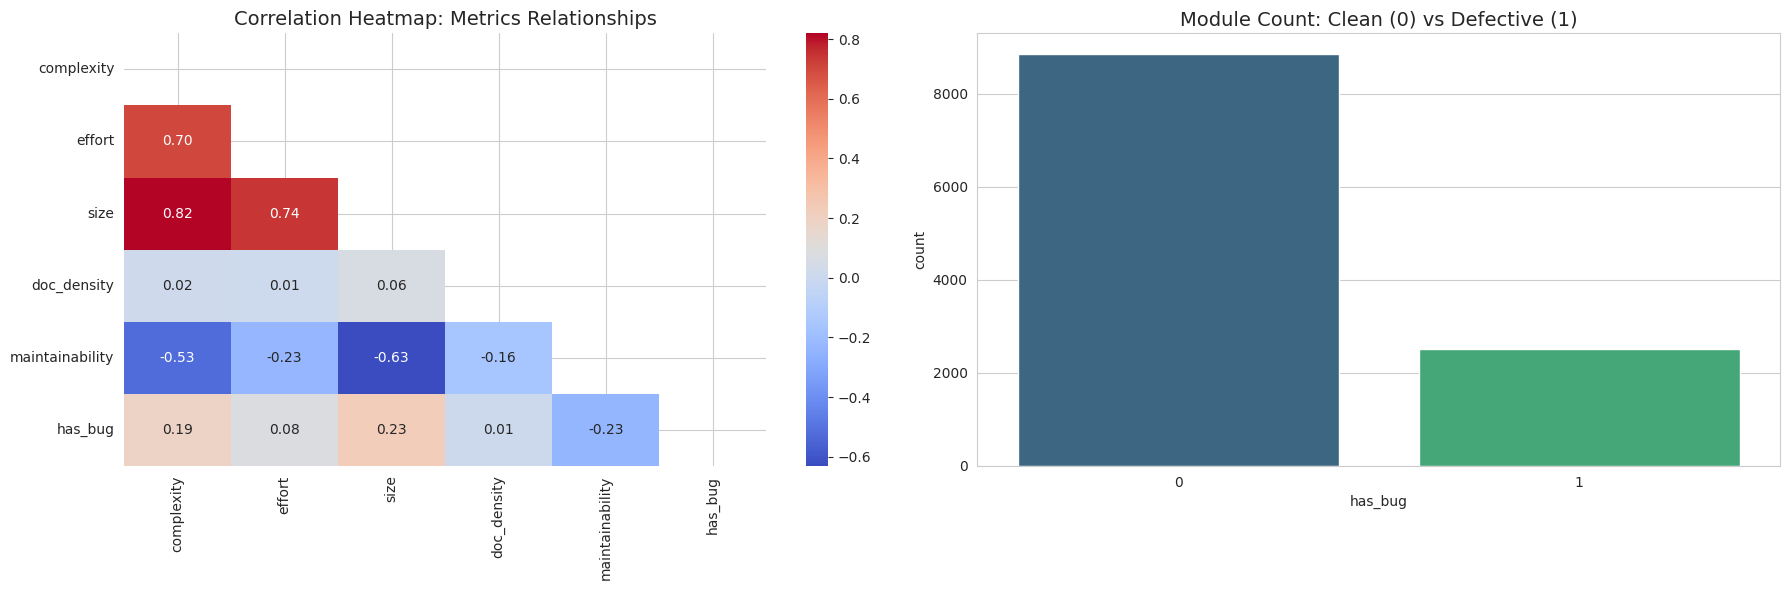

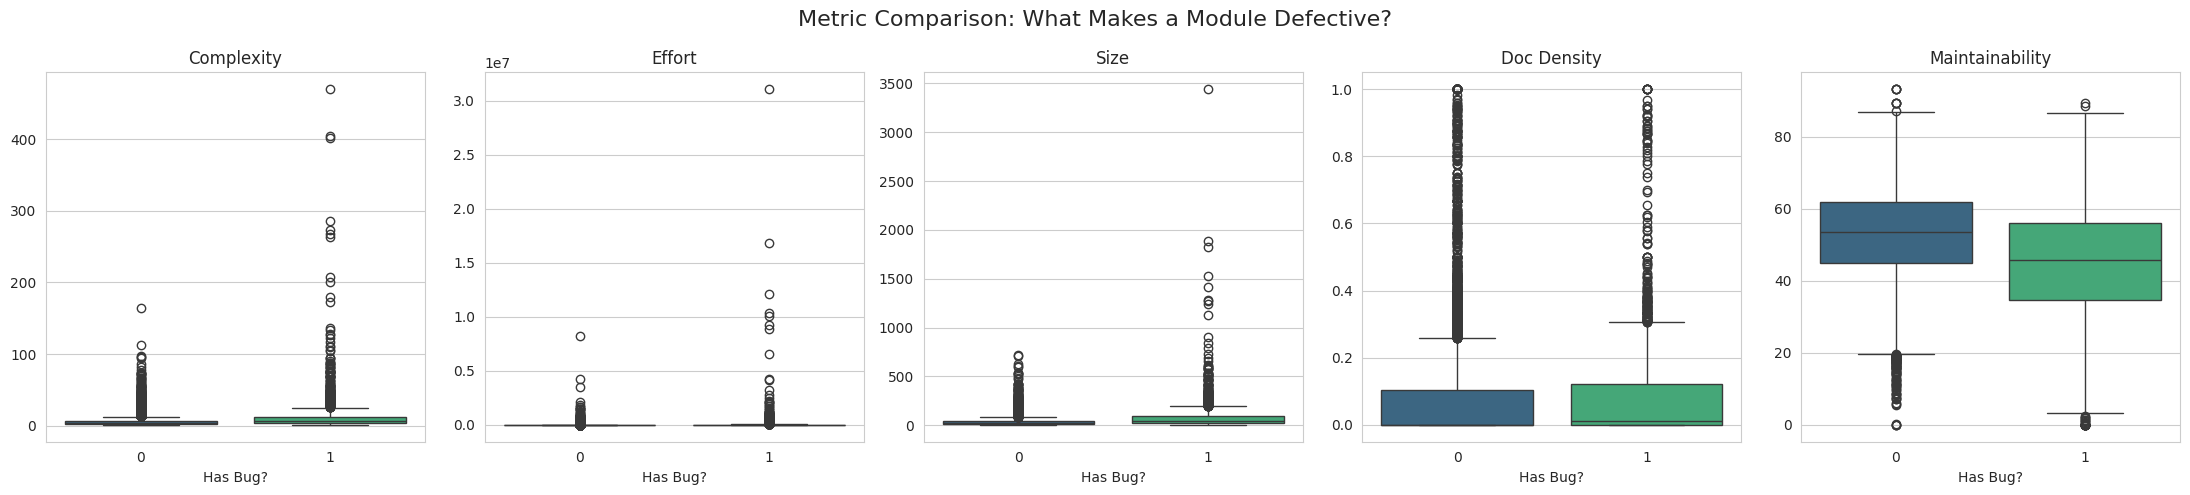

In [33]:
# Visual configuration
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

# --- CHART 1: Correlation Matrix ---
plt.subplot(1, 2, 1)
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
heatmap.set_title('Correlation Heatmap: Metrics Relationships', fontsize=14)

# --- CHART 2: Target Balance ---
plt.subplot(1, 2, 2)
ax = sns.countplot(x='has_bug', data=df, palette='viridis', hue='has_bug', legend=False)
ax.set_title('Module Count: Clean (0) vs Defective (1)', fontsize=14)
plt.tight_layout()
plt.show()

# --- CHART 3: Feature Distributions (Boxplots) ---
fig, axes = plt.subplots(1, 5, figsize=(22, 5))
fig.suptitle('Metric Comparison: What Makes a Module Defective?', fontsize=16)

for i, col in enumerate(FEATURE_COLUMNS):
    sns.boxplot(x='has_bug', y=col, data=df, palette='viridis', ax=axes[i], hue='has_bug', legend=False)
    axes[i].set_title(col.replace('_', ' ').title())
    axes[i].set_xlabel("Has Bug?")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

#### Correlation Heatmap
The heatmap reveals critical relationships between our features:

| Relationship | Correlation | Interpretation |
|--------------|-------------|----------------|
| `effort` ↔ `size` | **Strong (+0.7~0.9)** | Larger modules require more effort — expected |
| `complexity` ↔ `effort` | **Moderate (+0.5~0.7)** | Complex code is harder to develop |
| `maintainability` ↔ `complexity` | **Negative (-0.4~-0.6)** | High complexity = low maintainability |
| `doc_density` ↔ `has_bug` | **Weak (~0.0)** | Documentation alone doesn't prevent bugs |

<br>

> **Key insight:** Features are not redundant — each captures different aspects of code quality.

#### Class Distribution
The bar chart confirms our **80/20 imbalance**. This validates that:
- Most code in real projects works correctly
- Defect prediction is a **needle-in-haystack** problem
- Our model must be sensitive to the minority class (bugs)

#### Feature Boxplots — The "Defect Signature"
Comparing clean vs defective modules reveals patterns:

| Feature | Defective Modules Tend To Have... | Why It Matters |
|---------|-----------------------------------|----------------|
| `complexity` | **Higher median** | More paths = more places to fail |
| `effort` | **Higher values + outliers** | Rushed/complex development = bugs |
| `size` | **Larger modules** | More code = more opportunities for errors |
| `maintainability` | **Lower scores** | Hard-to-maintain code accumulates defects |
| `doc_density` | **Similar distribution** | Comments don't guarantee quality |


### Data Analysis Conclusion

Our exploratory analysis validates that the dataset is suitable for the project objectives:

1. **Characterization achieved** — We identified clear correlations between complexity metrics and defect presence
2. **Features are meaningful** — Defective modules show distinct patterns in complexity, effort, and maintainability
3. **Class imbalance noted** — Will require handling during model training (class weights, SMOTE, etc.)
4. **Ready for modeling** — Clean data, numeric features, no missing values

<br>

---

<br>

// Colocamos sistema de reglas, justificamos, y ejecutamos el codigo

<br>

---

<br>

// Comparativa entre métodos clásicos y profundos, 

<br>

---

<br>

// Toma de Decisiones / Búsqueda